<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Getting-started" data-toc-modified-id="Getting-started-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Getting started</a></span><ul class="toc-item"><li><span><a href="#Helper-functions" data-toc-modified-id="Helper-functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Helper functions</a></span></li><li><span><a href="#Inspecting-data" data-toc-modified-id="Inspecting-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Inspecting data</a></span></li></ul></li><li><span><a href="#Train-a-simple-convnet-(using-Pytorch/fastai)" data-toc-modified-id="Train-a-simple-convnet-(using-Pytorch/fastai)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train a simple convnet (using Pytorch/fastai)</a></span><ul class="toc-item"><li><span><a href="#Simple-convnet" data-toc-modified-id="Simple-convnet-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Simple convnet</a></span></li><li><span><a href="#Construct-a-fastai-learner-object" data-toc-modified-id="Construct-a-fastai-learner-object-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Construct a fastai <code>learner</code> object</a></span></li><li><span><a href="#Understanding-the-number-of-parameters" data-toc-modified-id="Understanding-the-number-of-parameters-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Understanding the number of parameters</a></span></li><li><span><a href="#Finding-an-optimal-learning-rate" data-toc-modified-id="Finding-an-optimal-learning-rate-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Finding an optimal learning rate</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#More-training:-learning-rate-annealing" data-toc-modified-id="More-training:-learning-rate-annealing-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>More training: learning rate annealing</a></span></li><li><span><a href="#Making-predictions" data-toc-modified-id="Making-predictions-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Making predictions</a></span></li></ul></li><li><span><a href="#Learning-rate-annealing" data-toc-modified-id="Learning-rate-annealing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Learning rate annealing</a></span></li><li><span><a href="#A-deeper-convnet" data-toc-modified-id="A-deeper-convnet-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>A deeper convnet</a></span><ul class="toc-item"><li><span><a href="#Use-test-time-augmentation" data-toc-modified-id="Use-test-time-augmentation-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Use test-time augmentation</a></span></li></ul></li><li><span><a href="#Using-a-fastai-resnet-model" data-toc-modified-id="Using-a-fastai-resnet-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Using a <code>fastai</code> resnet model</a></span></li><li><span><a href="#Using-a-pretrained-(frozen)-resnet" data-toc-modified-id="Using-a-pretrained-(frozen)-resnet-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Using a pretrained (frozen) resnet</a></span></li><li><span><a href="#Using-a-pretrained-resnet-with-layered-learning-rates" data-toc-modified-id="Using-a-pretrained-resnet-with-layered-learning-rates-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Using a pretrained resnet with layered learning rates</a></span><ul class="toc-item"><li><span><a href="#Initial-fine-tuning" data-toc-modified-id="Initial-fine-tuning-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Initial fine-tuning</a></span></li><li><span><a href="#Unfreeze-early-layer-groups" data-toc-modified-id="Unfreeze-early-layer-groups-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Unfreeze early layer groups</a></span></li></ul></li></ul></div>

# Getting started

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torch 

from IPython.display import display

In [2]:
torch.cuda.is_available()

False

## Helper functions

In [3]:
sys.path.append('../src')
from multiclass import *

In [4]:
def load_image(idx, df, ax=None, annotate=True):
    """Helper function to display and annotate image"""
    
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        
    Z_true, Z_pred = df.iloc[idx]
    name = df.index[idx]
    
    # get image
    image = plt.imread(f'{PATH}/test/{name}.jpg')
    ax.imshow(image)
    ax.axis('off')
    
    # label
    if annotate:
        fontdict = dict(color='white', size=18)
        #ax.text(0.5, 0.9, f'{name}', fontdict=fontdict, transform=ax.transAxes, ha='center', va='bottom')
        ax.text(0.95, 0.125, r'$Z_{\rm true}$' + f' = {Z_true:.3f}', fontdict=fontdict, transform=ax.transAxes, ha='right', va='bottom')
        ax.text(0.95, 0.025, r'$Z_{\rm pred}$' + f' = {Z_pred:.3f}', fontdict=fontdict, transform=ax.transAxes, ha='right', va='bottom')

## Inspecting data

In [5]:
PATH = os.path.abspath('..')
!ls {PATH}

catalogs	     environment.yml  images   models	 README.md  test  train
environment-cpu.yml  get_images.sh    LICENSE  notebook  src	    tmp


In [6]:
!ls {PATH}/catalogs/*.csv

/home/john/projects/convnet-demo/catalogs/test.csv
/home/john/projects/convnet-demo/catalogs/train.csv


In [7]:
train_label_csv = f'{PATH}/catalogs/train.csv'
df = pd.read_csv(train_label_csv, index_col=0)

display(df.sample(5, random_state=1234))

,oh_p50
objID,
1237657119477334357,8.459984
1237658917995086018,8.826601
1237658493346644079,8.583775
1237657775005630813,8.994787
1237668496849830008,8.984790


In [8]:
# save a subset of the training data (20%) for validation
n = len(df)
val_idxs = get_cv_idxs(n, val_pct=0.2)

Here we're looking at two columns in a `pandas` DataFrame: the SDSS `objID` and also the [O/H] gas-phase metallicity as determined from SDSS spectroscopy.

In [9]:
display(df.describe())

,oh_p50
count,400.000000
mean,8.901004
std,0.199803
min,8.133490
25%,8.824294
50%,8.950793
75%,9.047316
max,9.260791


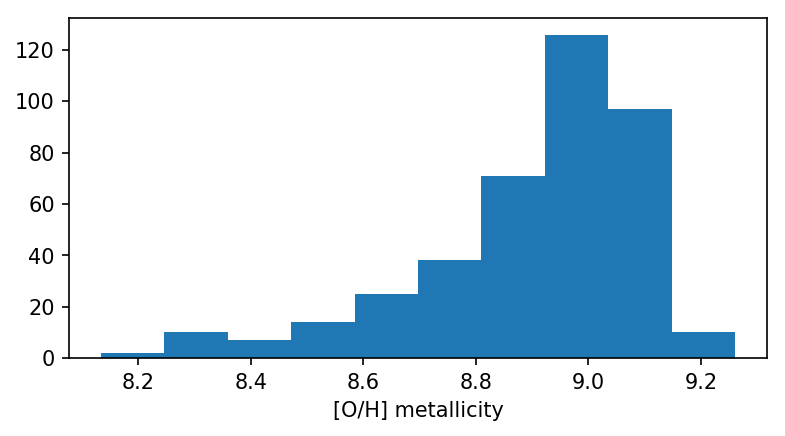

In [10]:
plt.figure(figsize=(6,3), dpi=150)
plt.hist(df.oh_p50)
plt.xlabel('[O/H] metallicity');

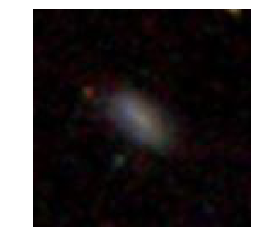

In [11]:
image = plt.imread(f'{PATH}/train/1237657119477334357.jpg')
plt.imshow(image)
plt.axis('off');

# Train a simple convnet (using Pytorch/fastai)

## Simple convnet 
Inspired by a [notebook](https://github.com/richardagalvez/basic-intro-pytorch) by R. Galavez

In [12]:
class SimpleCNN(nn.Module):
    """A simple convnet that takes in a three-color, 128x128 pixel 
    image, and outputs a single regressed quantity.
    """
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(32*32*32, 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## Construct a fastai `learner` object

In [13]:
# image size
sz = 128

# batch size
bs = 4

# architecture
arch = SimpleCNN()

In [14]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4)

In [15]:
# construct fastai learner object 
learn = ConvLearner.from_model_data(arch, data)

# IMPORTANT! make sure we're using the RMSE loss function
learn.crit = rmse

In [16]:
display(learn)

print('Number of parameters:')
display([o.numel() for o in learn.model.parameters()])

SimpleCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (fc): Linear(in_features=32768, out_features=1, bias=True)
)

Number of parameters:


[1200, 16, 16, 16, 12800, 32, 32, 32, 32768, 1]

In [17]:
display(learn.summary())

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 16, 128, 128]),
                           ('trainable', True),
                           ('nb_params', 1216)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 16, 128, 128]),
                           ('output_shape', [-1, 16, 128, 128]),
                           ('trainable', True),
                           ('nb_params', 32)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 16, 128, 128]),
                           ('output_shape', [-1, 16, 128, 128]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 16, 128, 128]),
                           ('output_shape', [-1, 16, 64, 64]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 16, 64, 64]

## Understanding the number of parameters
* **(Layer 1)** We find $16 \times 5 \times 5 \times 32 = 1200$, plus $16$ (for bias terms), and then $2\times 16$ for the BatchNorm mean and standard deviation. ✓
* **(Layer 2)** $32 \times (5 \times 5 \times 16 + 1) = 12832$, and then $2 \times 32$ for BatchNorm ✓
* **(Fully connected)** $32 \times 32 \times 32 + 1 = 32769$ ✓

## Finding an optimal learning rate

Why is this important? It can make gradient descent significantly faster or slower (from [Jeremy Jordan](https://www.jeremyjordan.me/nn-learning-rate/)):
![](https://cdn-images-1.medium.com/freeze/max/1000/1*An4tZEyQAYgPAZl396JzWg.png)

An algorithm proposed by [L. Smith (2015)](https://arxiv.org/abs/1506.01186) allows us to find an optimal starting learning rate. We "probe" the network using logarithmically increasing learning rates, in order to see how the loss function responds. If it continues to decrease, then our learning rate is suitable for training.

**This is built into `fastai` and is one of its most useful features!**

 80%|████████  | 64/80 [00:07<00:01,  8.60it/s, loss=131] 


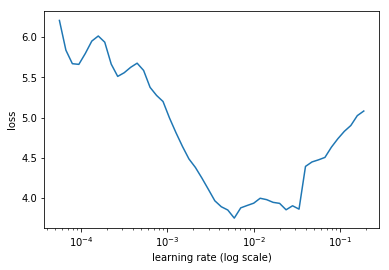

In [18]:
learn.lr_find()
learn.sched.plot()

Recall that we only have 320 training + 80 validation examples, so for a batch size of 4, we expect 80 iterations per epoch. (A batch size of 4 is tiny, but basically unavoidable!)

Anyway, here it appears that at $3 \times 10^{-3}$ the learning rate bottoms out. We'll select about an order of magnitude below this, or $3\times 10^{-4}$, since that tends to work well.

## Training

epoch      trn_loss   val_loss                            
    0      1.279502   0.321     
    1      0.828857   0.971818                             



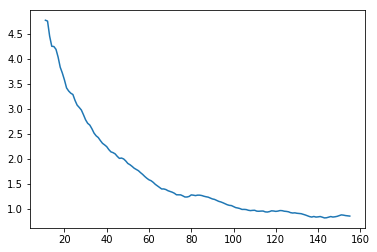

In [19]:
lr = 3e-4

# train model for two epochs
learn.fit(lr, n_cycle=2)

# show loss vs. iteration
learn.sched.plot_loss()

**More training...**

Since the RMSE still appears to be improving, we'll keep training with the same learning rate.

epoch      trn_loss   val_loss                             
    0      0.632344   0.73629   



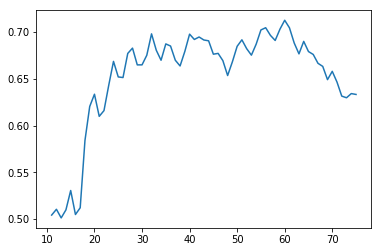

In [20]:
learn.fit(lr, 1)
learn.sched.plot_loss()

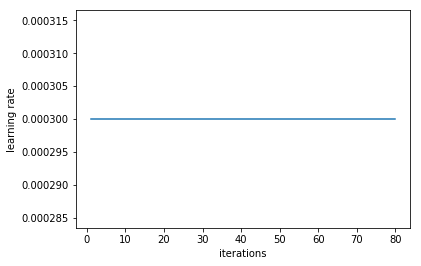

In [21]:
learn.sched.plot_lr()

## More training: learning rate annealing

Why would we do this? Well the learning rate is effectively the step size for traversing the loss function space. I like to think about it as re-scaling the space, as illustrated by [Dinh et al. (2017)](https://arxiv.org/pdf/1703.04933.pdf):

![](https://cdn-images-1.medium.com/max/800/1*OL2g-qtD5OwcgtRNGby2sg.png)

Let's now *anneal* the learning rate by an order of magnitude and fit two more epochs.

epoch      trn_loss   val_loss                             
    0      0.404989   0.219646  
    1      0.367889   0.185889                             



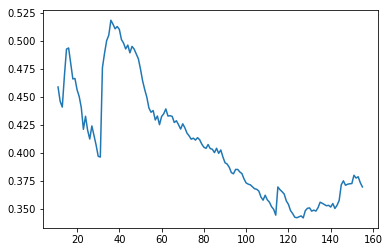

In [22]:
lr = 3e-5
learn.fit(lr, n_cycle=2)
learn.sched.plot_loss()

More annealing and training.

epoch      trn_loss   val_loss                             
    0      0.287032   0.172905  
    1      0.267802   0.161021                             



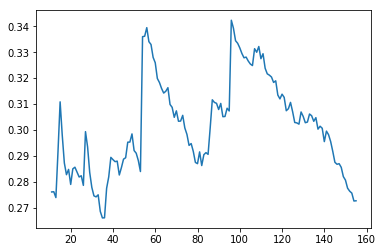

In [23]:
lr = 1e-5
learn.fit(lr, n_cycle=2)
learn.sched.plot_loss()

Here the validation loss is bottoming out at about RMSE $\approx 0.20$ dex.

## Making predictions

In [24]:
# run test (no augmentation)
Z_pred = learn.predict(is_test=True)

In [25]:
# construct answer key
test_names = np.array([os.path.split(fname)[1][:-4] for fname in learn.data.test_ds.fnames], dtype=np.int64)
df_test = pd.read_csv(f'{PATH}/catalogs/test.csv', index_col=0)
Z_true = df_test.loc[test_names].values

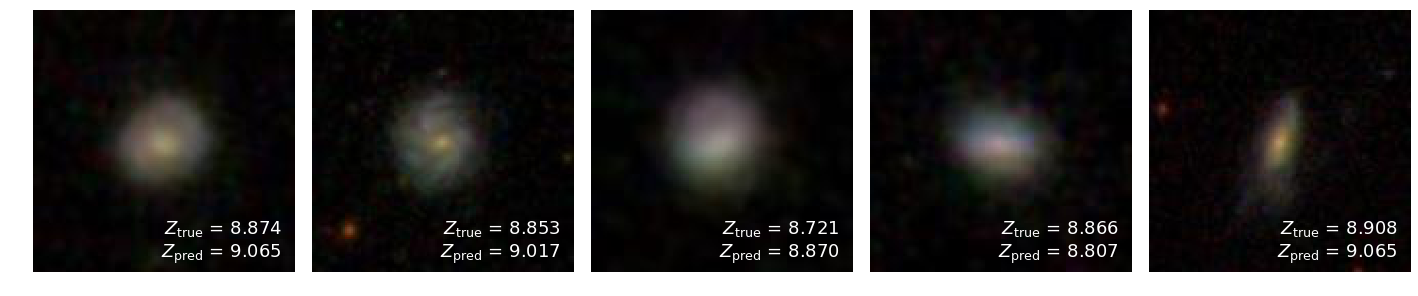

In [26]:
# show results
res = pd.DataFrame({'Z_pred': Z_pred.flatten(), 'Z_true': Z_true.flatten()}, index=test_names)

# random selection of five galaxies
rand = res.sample(frac=1., random_state=1234)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx in range(5):
    ax = axes.flat[idx]
    load_image(idx, rand, ax=ax)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.03, hspace=0.03)

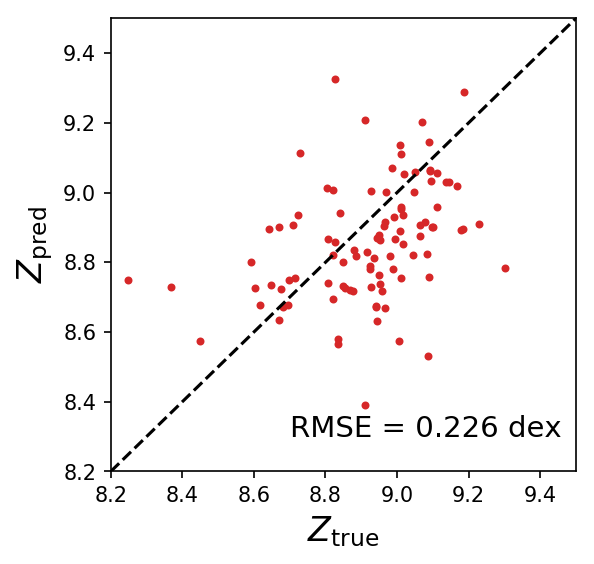

In [27]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.7, 8.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');

Not bad for a net with only two convolutional layers, and about **80 seconds** on my Dell XPS13...

# Learning rate annealing

In [29]:
sz = 128
bs = 4
arch = SimpleCNN()

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4)

# remember that you need to set the loss function criterion EVERY TIME
learn = ConvLearner.from_model_data(arch, data)
learn.crit = rmse

Here we will use a different strategy. We'll now use a flat learning rate for two epochs, cosine annealing for one epoch, and then cosine anneal for two epochs, and then cosine anneal for four epochs (a total of three *cycles* and seven *epochs*).

Note that dropout layers sometimes make the training loss worse than the validation loss. (This tends to be the case when we are not overfitting.)

In [30]:
# two epochs of flat learning rate training
learn.fit(3e-4, 2) 

# and then cosine annealing schedule 
learn.fit(1e-4, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      1.591339   0.279937  
    1      0.807255   0.901026                             



epoch      trn_loss   val_loss                             
    0      0.407936   0.234357  
    1      0.539161   0.514648                             
    2      0.379909   0.175841                             
    3      0.392255   0.488444                             
    4      0.366533   0.241755                             
    5      0.297765   0.164306                             
    6      0.245897   0.151068                             



[array([0.15107])]

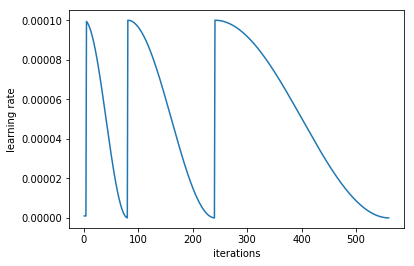

In [31]:
learn.sched.plot_lr()

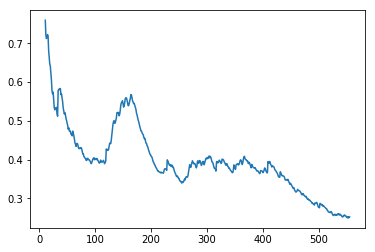

In [32]:
learn.sched.plot_loss()

In [33]:
Z_pred = learn.predict(is_test=True)

In [34]:
print(f'Test RMSE = {rmse_np(Z_true, Z_pred):.3f} dex')

Test RMSE = 0.183 dex


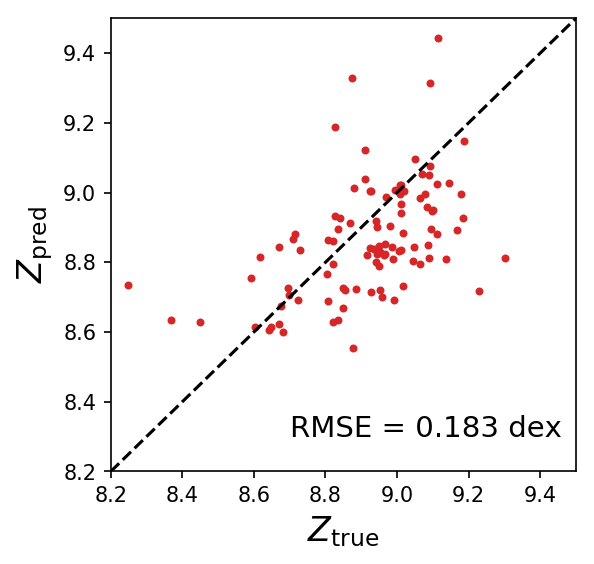

In [35]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.7, 8.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');

# A deeper convnet
Inspired by the [fastai notebook](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson7-cifar10.ipynb)

In [28]:
class ConvNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, layers[0], kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(layers[0]),
            nn.MaxPool2d(2))
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(layers[i], layers[i + 1], kernel_size=5, padding=2),
                nn.BatchNorm2d(layers[i + 1]),
                nn.ReLU(),
                nn.MaxPool2d(2))
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], 1)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return self.out(x).view(-1)

In [29]:
arch = ConvNet([16, 32, 64])
sz = 128
bs = 4

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4)

learn = ConvLearner.from_model_data(arch, data)
learn.crit = rmse

In [30]:
display(learn)
display([o.numel() for o in learn.model.parameters()])

ConvNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    )
  )
  (out): Linear(in_features=64, out_features=1, bias=True)
)

[2352, 16, 16, 16, 12800, 32, 32, 32, 51200, 64, 64, 64, 64, 1]

In [31]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 16, 64, 64]),
                           ('trainable', True),
                           ('nb_params', 2368)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 16, 64, 64]),
                           ('output_shape', [-1, 16, 64, 64]),
                           ('trainable', True),
                           ('nb_params', 32)])),
             ('MaxPool2d-3',
              OrderedDict([('input_shape', [-1, 16, 64, 64]),
                           ('output_shape', [-1, 16, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 16, 32, 32]),
                           ('output_shape', [-1, 32, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 12832)])),
             ('BatchNorm2d-5',
            

 80%|████████  | 64/80 [00:03<00:00, 24.49it/s, loss=19.9]


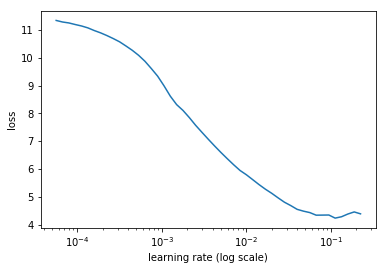

In [32]:
learn.lr_find()
learn.sched.plot()

In [33]:
learn.fit(3e-3, 1)
learn.fit(1e-3, 1)

epoch      trn_loss   val_loss                             
    0      0.923855   1.210851  



epoch      trn_loss   val_loss                             
    0      0.265303   0.167196  



[array([0.1672])]

epoch      trn_loss   val_loss                             
    0      0.196335   0.248451  
    1      0.18208    0.166845                             



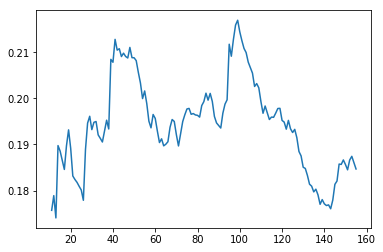

In [34]:
# some cosine annealing
learn.fit(3e-4, 1, cycle_len=2)
learn.sched.plot_loss()

epoch      trn_loss   val_loss                             
    0      0.188326   0.168099  
    1      0.173517   0.160655                             
    2      0.192542   0.152528                             
    3      0.190071   0.149949                             



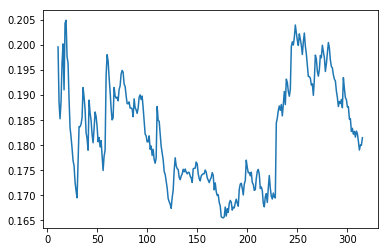

In [35]:
learn.fit(3e-5, 1, cycle_len=4)
learn.sched.plot_loss()

epoch      trn_loss   val_loss                             
    0      0.178227   0.168229  
    1      0.186014   0.176024                             
    2      0.174887   0.166487                             
    3      0.184478   0.174217                             
    4      0.175936   0.16846                              
    5      0.176195   0.163021                             
    6      0.182066   0.155595                             



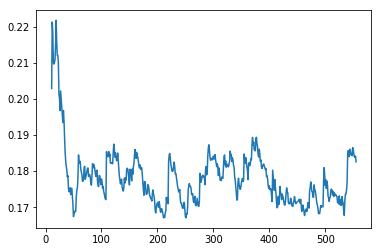

In [36]:
learn.fit(1e-5, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

Not bad for my laptop...

In [37]:
Z_pred = learn.predict(is_test=True)
print(f'Test RMSE = {rmse_np(Z_true, Z_pred):.3f} dex')

Test RMSE = 0.234 dex


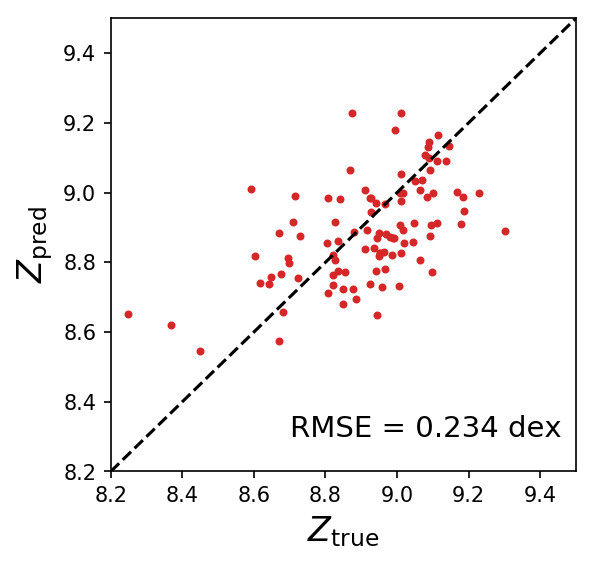

In [38]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.7, 8.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');

## Use test-time augmentation

In [39]:
Z_pred, _ = learn.TTA(is_test=True)
Z_pred = Z_pred.mean(axis=0)
print(f'Test RMSE = {rmse_np(Z_true, Z_pred):.3f} dex')

Test RMSE = 0.224 dex                        


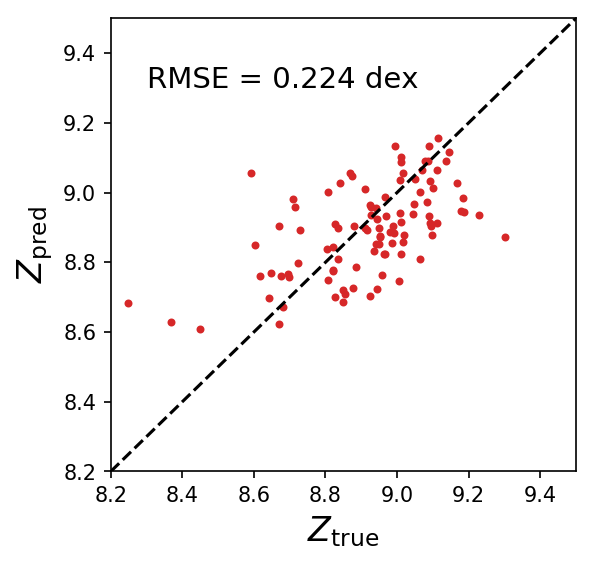

In [40]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.3, 9.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');

# Using a `fastai` resnet model

In [25]:
arch = resnet18
sz = 128
bs = 8

data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4)

learn = ConvLearner.pretrained(arch, data, pretrained=False, precompute=False)
learn.crit = rmse

In [31]:
learn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [26]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

 90%|█████████ | 36/40 [00:10<00:01,  3.53it/s, loss=91.4]

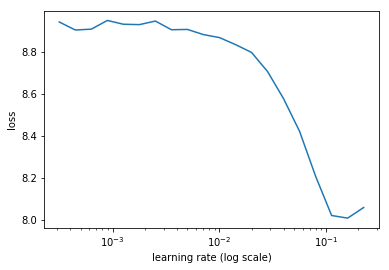

In [27]:
learn.lr_find()
learn.sched.plot()

In [28]:
lr = 1e-2

learn.fit(lr, 4)

epoch      trn_loss   val_loss                            
    0      4.515972   0.747432  
    1      2.93197    1.060693                            
    2      2.61392    1.167109                            
    3      2.386198   0.888005                            


[array([0.88801])]

epoch      trn_loss   val_loss                            
    0      1.733786   0.464196  
    1      1.615899   0.368842                            
    2      1.574324   0.31112                             
    3      1.359333   0.445337                            
    4      1.279528   0.325263                            
    5      1.290891   0.315239                            
    6      1.331306   0.307145                            
    7      1.195604   0.267218                            
    8      1.075631   0.228369                            
    9      0.966164   0.198482                             
    10     0.931907   0.258804                             
    11     0.905719   0.200691                             
    12     0.937485   0.197683                             
    13     0.876833   0.208037                             


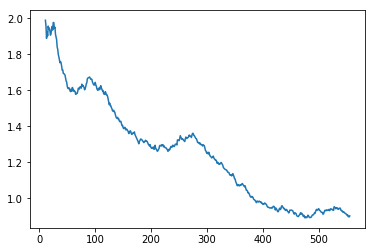

In [29]:
learn.fit(1e-3, 3, cycle_len=2, cycle_mult=2)
learn.sched.plot_loss()

epoch      trn_loss   val_loss                             
    0      0.853468   0.202115  
    1      0.865638   0.191482                             
    2      0.858982   0.187044                             
    3      0.844754   0.221406                             
    4      0.856909   0.212621                             
    5      0.836464   0.19102                              
    6      0.827929   0.203193                             


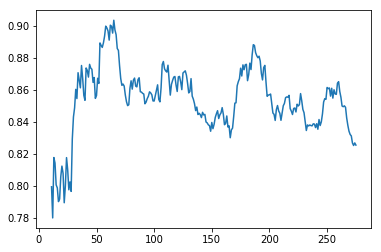

In [30]:
learn.fit(1e-4, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

In [32]:
Z_pred, _ = learn.TTA(is_test=True)
Z_pred = Z_pred.mean(axis=0)
print(f'Test RMSE = {rmse_np(Z_true, Z_pred):.3f} dex')

Test RMSE = 0.209 dex                        


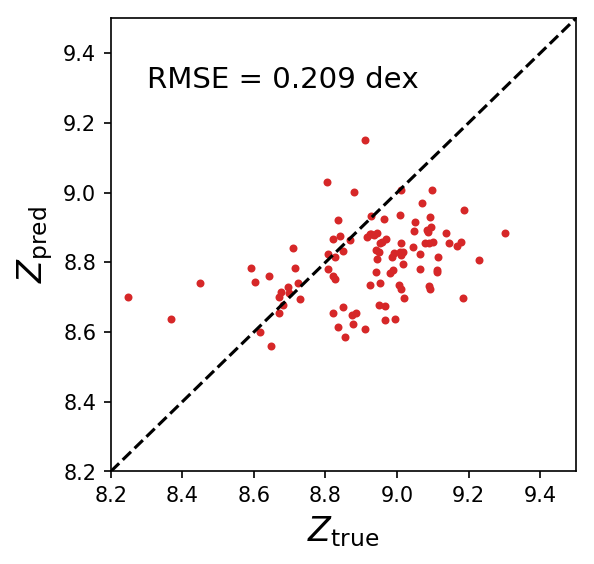

In [33]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.3, 9.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');

# Using a pretrained (frozen) resnet

In [34]:
arch = resnet18
sz = 128
bs = 8

data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4)
learn = ConvLearner.pretrained(arch, data, pretrained=True, precompute=True)
learn.crit = rmse

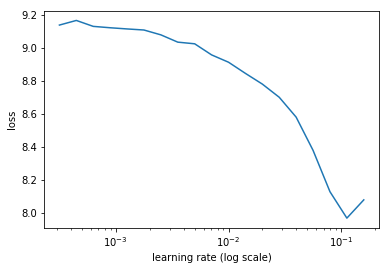

In [35]:
learn.lr_find()
learn.sched.plot()

In [36]:
lr = 1e-2

learn.fit(lr, 20)

epoch      trn_loss   val_loss                            
    0      4.759911   2.347885  
    1      3.143946   1.595685                            
    2      2.672667   1.175189                            
    3      2.277432   1.042578                            
    4      2.037245   1.338771                            
    5      1.784912   1.413135                            
    6      1.725283   1.476227                            
    7      1.487585   1.016901                             
    8      1.420553   1.258712                            
    9      1.25276    0.816341                            
    10     1.139565   0.608191                            
    11     1.02405    0.565205                            
    12     1.005954   0.381613                             
    13     0.947725   0.412059                             
    14     0.860743   0.394078                             
    15     0.773282   0.433515                             
    16     0.74425

[array([0.36466])]

epoch      trn_loss   val_loss                             
    0      0.479984   0.23216   
    1      0.448146   0.180872                             
    2      0.463387   0.222262                              
    3      0.44059    0.17578                               
    4      0.417682   0.189271                             
    5      0.412555   0.167148                             
    6      0.38836    0.170595                             
    7      0.389208   0.208216                             
    8      0.398996   0.216743                             
    9      0.383332   0.167593                             
    10     0.361946   0.174982                             
    11     0.348614   0.185044                             
    12     0.338769   0.171148                             
    13     0.338306   0.173003                             
    14     0.33475    0.168526                             
    15     0.339701   0.170525                             
    1

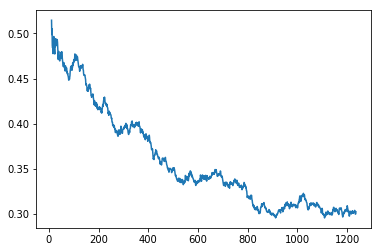

In [37]:
learn.fit(1e-3, 5, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

epoch      trn_loss   val_loss                             
    0      0.318182   0.153385  
    1      0.30624    0.157773                             
    2      0.285364   0.162692                             
    3      0.282024   0.157586                             
    4      0.292986   0.148659                             
    5      0.294847   0.149088                             
    6      0.293889   0.145886                             
    7      0.29735    0.154845                             
    8      0.290649   0.161547                             
    9      0.284211   0.159664                             
    10     0.285903   0.165596                             
    11     0.288351   0.161193                             
    12     0.285134   0.157983                             
    13     0.288199   0.152822                             
    14     0.301832   0.147533                             
    15     0.302718   0.160668                             
    16 

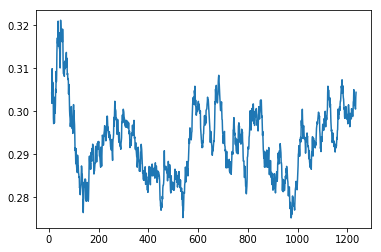

In [38]:
learn.fit(1e-4, 5, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

epoch      trn_loss   val_loss                             
    0      0.297007   0.151292  
    1      0.287342   0.151254                             
    2      0.276444   0.148947                             
    3      0.277696   0.154501                             
    4      0.281544   0.14921                              
    5      0.29597    0.143419                             
    6      0.291495   0.148041                             
    7      0.294717   0.145743                             
    8      0.275441   0.146957                             
    9      0.283986   0.143757                             
    10     0.280561   0.148548                             
    11     0.279875   0.142741                             
    12     0.267347   0.147104                             
    13     0.283394   0.145285                             
    14     0.277638   0.162193                             
    15     0.293357   0.149275                             
    16 

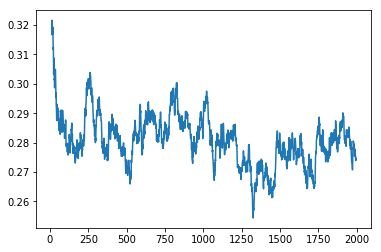

In [39]:
learn.fit(1e-4, 1, cycle_len=50)
learn.sched.plot_loss()

In [40]:
Z_pred, _ = learn.TTA(is_test=True)
Z_pred = Z_pred.mean(axis=0)
print(f'Test RMSE = {rmse_np(Z_true, Z_pred):.3f} dex')

Test RMSE = 0.145 dex                        


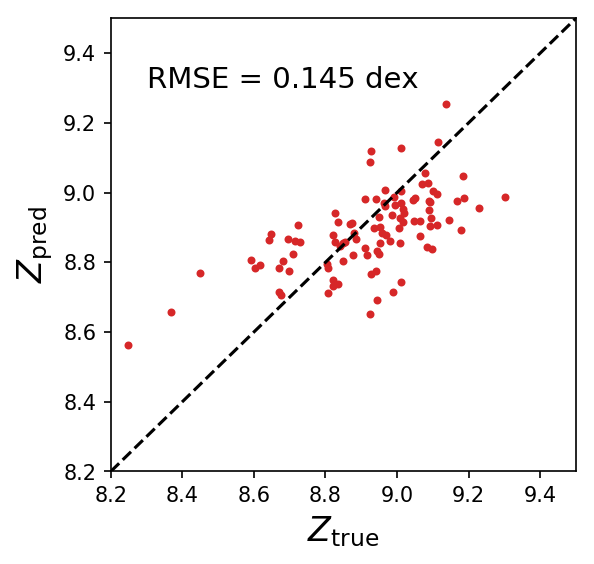

In [41]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.3, 9.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');

# Using a pretrained resnet with layered learning rates

In [42]:
arch = resnet18
sz = 128
bs = 8

data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4)

learn = ConvLearner.pretrained(arch, data, pretrained=True, precompute=True)
learn.crit = rmse

## Initial fine-tuning

In [43]:
learn.fit(1e-2, 20, cycle_len=1)
learn.fit(1e-3, 20, cycle_len=1)
learn.fit(1e-4, 20, cycle_len=1)

epoch      trn_loss   val_loss                            
    0      5.863432   3.723183  
    1      3.516791   1.341908                            
    2      2.744822   1.304917                            
    3      2.357854   1.259554                            
    4      1.940991   0.667512                            
    5      1.642721   0.915565                            
    6      1.480826   0.949382                            
    7      1.384372   0.628605                            
    8      1.466699   0.524211                            
    9      1.374595   0.498389                            
    10     1.383627   0.591093                            
    11     1.273804   0.536443                            
    12     1.302638   0.771136                            
    13     1.309273   0.564489                            
    14     1.222559   0.540372                            
    15     1.232991   0.555962                            
    16     1.351518   0

epoch      trn_loss   val_loss                             
    0      0.808615   0.550934  
    1      0.837507   0.433527                             
    2      0.810601   0.462394                             
    3      0.760174   0.364286                             
    4      0.723822   0.365612                             
    5      0.670173   0.342986                             
    6      0.647216   0.299725                             
    7      0.607964   0.262573                             
    8      0.588064   0.305832                             
    9      0.559089   0.291131                             
    10     0.569202   0.25806                              
    11     0.544261   0.258461                             
    12     0.545709   0.283804                             
    13     0.507159   0.257391                             
    14     0.50533    0.232098                             
    15     0.4965     0.238723                             
    16 

epoch      trn_loss   val_loss                             
    0      0.453228   0.207933  
    1      0.445217   0.209819                             
    2      0.488649   0.206807                             
    3      0.484161   0.20179                              
    4      0.46897    0.203596                             
    5      0.444858   0.196084                             
    6      0.475574   0.198625                             
    7      0.474002   0.20638                              
    8      0.480235   0.206065                             
    9      0.471576   0.210286                             
    10     0.453127   0.201112                             
    11     0.443613   0.208658                             
    12     0.443269   0.199802                             
    13     0.458345   0.214978                             
    14     0.45217    0.219289                             
    15     0.454056   0.206646                             
    16 

[array([0.18935])]

In [44]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

## Unfreeze early layer groups

In [45]:
learn.unfreeze()

In [ ]:
lrs = [1e-6, 3e-5, 1e-5]

learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                             
    0      0.442171   0.200067  
    1      0.441962   0.203135                             
    2      0.450605   0.199751                             
    3      0.484929   0.195056                             


In [ ]:
learn.summary()

In [ ]:
learn.sched.plot_loss()

In [ ]:
Z_pred, _ = learn.TTA(is_test=True)
Z_pred = Z_pred.mean(axis=0)
print(f'Test RMSE = {rmse_np(Z_true, Z_pred):.3f} dex')

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.3, 9.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');